In [1]:
# SYMBOLIC MODELLING CODE

# import libraries
import sympy as sym
import numpy as np

from IPython.display import display, HTML #for pretty printing
display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 32em; }</style>"))

# create symbolic variables

# system parameters
g = sym.symbols('g')
m1 ,  m2,  m3 = sym.symbols([ 'm_{body}', 'm_{thigh}', 'm_{shank}']) # mass of links
l1 ,  l2,  l3 = sym.symbols([ 'l_{body}', 'l_{thigh}', 'l_{shank}']) # length of links
In1, In2, In3 = sym.symbols(['In_{body}','In_{thigh}','In_{shank}']) # moment of intertia of links

# generalized coordinates

# body x position, body y position, body angle, leg angle, prismatic joint extension
x  ,   dx,   ddx = sym.symbols(['x'             ,'\dot{x}'             ,'\ddot{x}']) # note that x and y are not fixed as they were in prev tutorials
y  ,   dy,   ddy = sym.symbols(['y'             ,'\dot{y}'             ,'\ddot{y}'])
th1, dth1, ddth1 = sym.symbols(['\\theta_{body}','\dot{\\theta_{body}}','\ddot{\\theta_{body}}'])
th2, dth2, ddth2 = sym.symbols(['\\theta_{leg}' ,'\dot{\\theta_{leg}}' ,'\ddot{\\theta_{leg}}'])
s  ,   ds,   dds = sym.symbols(['s'             ,'\dot{s}'             ,'\ddot{s}'])

q   = sym.Matrix([  [x],  [y],  [th1],  [th2],  [s]]) #group into matrices
dq  = sym.Matrix([ [dx], [dy], [dth1], [dth2], [ds]])
ddq = sym.Matrix([[ddx],[ddy],[ddth1],[ddth2],[dds]])

#--------------------------------------------------------------------------------------------------

# STEP 1: system space coordinates written in terms of the generalised coordinates

# helper functions
def Rotate(v, th):
    # the 2D system space coordinates are [x;y;th], so we need a rotation function that can work with this
    # NOTE: this matrix is technically for *undoing* a rotation
    R = sym.Matrix([[sym.cos(th), -sym.sin(th), 0],
                    [sym.sin(th),  sym.cos(th), 0],
                    [          0,            0, 1]]) # rotation matrix, augmented because of the theta element of the vector
    S = sym.Matrix([[0],[0],[th]]) # angle of rotation
    return R*v + S # coordinates after rotation

def GetXY(v):
    # this function is for applying a position-only offset (preserves the angle)
    vector_mask = sym.Matrix([[1],[1],[0]]) # gets rid of angle component of vector when multiplied elementwise
    return v.multiply_elementwise(vector_mask)

# positions of each link in their own reference frames
r0   = sym.Matrix([[x],      [y],[0]])
r1_1 = sym.Matrix([[0],      [0],[0]]) # writing it out just for consistency
r2_2 = sym.Matrix([[0],[-0.5*l2],[0]])
r3_3 = sym.Matrix([[0],[-0.5*l3],[0]])
rs_2 = sym.Matrix([[0],     [-s],[0]])

# Absolute orientations

# positions of each link, moved into the inertial frame
r1_0 = Rotate(r1_1, th1) + GetXY(r0)

r2_1 = Rotate(r2_2, th2-th1) + GetXY(r1_1)
r2_0 = Rotate(r2_1, th1) + GetXY(r1_0)

r3_2 = r3_3 + rs_2 + GetXY(r2_2) # in order to add
r3_0 = Rotate(r3_2, th2) + GetXY(r2_0)

# joint and end positions. NOT STRICTLY NECESSARY, but makes plotting stuff easier.
rBodyL_0 = Rotate(sym.Matrix([[-0.5*l1],[0],[0]]), th1) + GetXY(r1_0)
rBodyR_0 = Rotate(sym.Matrix([[ 0.5*l1],[0],[0]]), th1) + GetXY(r1_0)

rKnee1_0 = Rotate(r2_2, th2) + GetXY(r2_0)
rKnee2_0 = Rotate(r2_2 + rs_2, th2) + GetXY(r2_0)

# Foot position -> necessary for ground contact forces
rFoot_0 = Rotate(r3_3, th2) + GetXY(r3_0)

#--------------------------------------------------------------------------------------------------

# STEP 2: generate expressions for the system space velocities

dr1 = r1_0.jacobian(q)*dq
dr2 = r2_0.jacobian(q)*dq
dr3 = r3_0.jacobian(q)*dq

drFoot = rFoot_0.jacobian(q)*dq

#--------------------------------------------------------------------------------------------------

# STEP 3: generate expressions for the kinetic and potential energy

# helper functions
def Ek(m, In, dr):
    InM = sym.Matrix([[m,0,0],[0,m,0],[0,0,In]])
    return 0.5*dr.T*InM*dr

def Ep(m, r):
    return sym.Matrix([m*g*r[1]])

# expressions
T = Ek(m1, In1, dr1) + Ek(m2, In2, dr2) + Ek(m3, In3, dr3)
V = Ep(m1, r1_0) + Ep(m2, r2_0) + Ep(m3, r3_0)

#--------------------------------------------------------------------------------------------------

# STEP 4: calculate each term of the Lagrange equation

# term 1
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 2 = 0
# term 3
Lg3 = T.jacobian(q) # partial of T in q

# term 4
Lg4 = V.jacobian(q) # partial of U in q

#--------------------------------------------------------------------------------------------------

# STEP 5: calculate generalized forces

tau, f, GRFx, GRFy = sym.symbols(['tau', 'F', 'GRF_{x}', 'GRF_{y}']) # arbitrary control torque
tau_l1 = sym.Matrix([[0],[0],[-tau]]) # the world frame torque at the hip, acting on the body
tau_l2 = sym.Matrix([[0],[0],[ tau]]) # the world frame torque at the hip, acting on the thigh
f_l2   = Rotate(sym.Matrix([[0],[ f],[0]]), th2) # the world frame force at the knee, acting on the thigh
f_l3   = Rotate(sym.Matrix([[0],[-f],[0]]), th2) # the world frame force at the knee, acting on the shank
GRF_l3 = sym.Matrix([[GRFx],[GRFy],[0]])

Qtau = r1_0.jacobian(q).T*tau_l1 + r2_0.jacobian(q).T*tau_l2
Qf = r2_0.jacobian(q).T*f_l2 + r3_0.jacobian(q).T*f_l3
QGRF = rFoot_0.jacobian(q).T*GRF_l3

Qtot = Qtau + Qf + QGRF
# -----------------------------------------------------------------------------------

# STEP 6: put it all together

EOM = Lg1 - Lg3 + Lg4 - Qtot.T
EOM = EOM.T

display(EOM[1].simplify())

-GRF_{y} + \ddot{\theta_{leg}}*(0.5*l_{shank}*m_{shank} + 1.0*l_{thigh}*m_{shank} + 0.5*l_{thigh}*m_{thigh} + 1.0*m_{shank}*s)*sin(\theta_{leg}) - 1.0*\ddot{s}*m_{shank}*cos(\theta_{leg}) + 1.0*\ddot{y}*(m_{body} + m_{shank} + m_{thigh}) + 1.0*\dot{\theta_{leg}}*\dot{s}*m_{shank}*sin(\theta_{leg}) + 0.5*\dot{\theta_{leg}}*(\dot{\theta_{leg}}*l_{thigh}*m_{thigh}*cos(\theta_{leg}) + 2*m_{shank}*(\dot{\theta_{leg}}*(0.5*l_{shank} + 1.0*l_{thigh} + 1.0*s)*cos(\theta_{leg}) + \dot{s}*sin(\theta_{leg}))) + g*m_{body} + g*m_{shank} + g*m_{thigh}

In [2]:
# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# VARIABLE LIST, sympy to pyomo

sym_list = [g,
            m1, m2, m3,
            l1, l2, l3,
            In1, In2, In3,
            x  ,  y, th1,   th2,  s,
            dx , dy, dth1, dth2, ds,
            ddx,ddy,ddth1,ddth2,dds,
            tau, f, GRFx, GRFy] # list of the symbols that will be substituted with inputs

def get_var_list(m,n):
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g]+\
               [m.m[l] for l in links]+\
               [m.len[l] for l in links]+\
               [m.In[l] for l in links]+\
               [m.q[n,dof] for dof in DOFs]+\
               [m.dq[n,dof] for dof in DOFs]+\
               [m.ddq[n,dof] for dof in DOFs]+\
               [m.fj[n,j] for j in joints]+\
               [m.GRF[n,dof] for dof in TDOFs]
    return var_list

# LAMBDIFY --------------------------------------------------------------------

func_map = {'sin':sin, 'cos':cos} 

DOFs  = ['x','y','th1','th2','s']
TDOFs = ['x','y']

links = ['body', 'thigh', 'shank']
joints = ['hip','knee']

plotpoints = ['bodyL', 'bodyR', 'hip', 'knee1', 'knee2', 'foot']

lamb_EOM  = {}
lamb_footp = {}
lamb_footv = {}
lamb_plotp = {}

for dof_i, dof in enumerate(DOFs):
    lamb_EOM[dof] = sym.lambdify(sym_list, EOM[dof_i],modules = [func_map])

for dof_i, dof in enumerate(TDOFs):
    lamb_footp[dof] = sym.lambdify(sym_list,rFoot_0[dof_i],modules = [func_map])
    lamb_footv[dof] = sym.lambdify(sym_list, drFoot[dof_i],modules = [func_map])

    lamb_plotp.update({('bodyL', dof) : sym.lambdify(sym_list, rBodyL_0[dof_i],modules = [func_map])})
    lamb_plotp.update({('bodyR', dof) : sym.lambdify(sym_list, rBodyR_0[dof_i],modules = [func_map])})
    lamb_plotp.update({('hip'  , dof) : sym.lambdify(sym_list,     r1_0[dof_i],modules = [func_map])})
    lamb_plotp.update({('knee1', dof) : sym.lambdify(sym_list, rKnee1_0[dof_i],modules = [func_map])})
    lamb_plotp.update({('knee2', dof) : sym.lambdify(sym_list, rKnee2_0[dof_i],modules = [func_map])})
    lamb_plotp.update({('foot' , dof) : sym.lambdify(sym_list,  rFoot_0[dof_i],modules = [func_map])})

In [3]:
mass = {'body': 0.5,
       'thigh': 0.25,
       'shank': 0.25}

length = {'body': 1.0,
         'thigh': 0.5,
         'shank': 0.5}

inertia = {'body': mass['body']*length['body']**2/12,
          'thigh': mass['thigh']*length['thigh']**2/12,
          'shank': mass['shank']*length['shank']**2/12}

In [33]:
def create_model(N,hm,mu):
    m = ConcreteModel()
    
    #SETS---------------------------------
    m.N    = RangeSet(N)
    m.DOF  = Set(initialize = DOFs)
    m.TDOF = Set(initialize = TDOFs)
    m.L    = Set(initialize = links)
    m.J    = Set(initialize = joints)
    m.pp   = Set(initialize = plotpoints)
    
    m.sgn = Set(initialize = ['ps','ng'])
    m.ground_constraints = Set(initialize = ['contact','sliding_ps','sliding_ng'])
    
    #PARAMS-------------------------------
    m.g   = Param(initialize = 9.81)
    m.mu  = Param(initialize = mu)
    
    m.m   = Param(m.L, initialize = mass)
    m.len = Param(m.L, initialize = length)
    m.In  = Param(m.L, initialize = inertia)
    
    #VARIABLES----------------------------
    #gen coordinates
    m.q   = Var(m.N, m.DOF)
    m.dq  = Var(m.N, m.DOF)
    m.ddq = Var(m.N, m.DOF)
    
    #forces
    m.fj  = Var(m.N, m.J)
    m.GRF = Var(m.N, m.TDOF)

# ------------------------------------------------------------------------------------------------------------------
    #TIME AND INTEGRATION

    # timestep
    m.hm = Param(initialize = hm, mutable = True) # master timestep
    m.h  = Var(m.N, bounds = (0.8,1.0))
    
    # Integration constraints 
    def BwEuler_p(m,n,dof): # Backward Euler integration for positions
        if n > 1:
            return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
        else:
            return Constraint.Skip
    m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

    def BwEuler_v(m,n,dof): # Backward Euler integration for velocities
        if n > 1:
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
        else:
            return Constraint.Skip 
    m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)
    
# ------------------------------------------------------------------------------------------------------------------
    # Equations of motion
    def dynamics(m,n,dof):
        var_list = get_var_list(m,n)
        return lamb_EOM[dof](*var_list) == 0
    m.dynamics = Constraint(m.N, m.DOF, rule = dynamics)
    
    # points for plotting
    m.plotp = Var(m.N, m.pp, m.TDOF)
    def def_plotp(m,n,pp,dof):
        var_list = get_var_list(m,n)
        return m.plotp[n,pp,dof] == lamb_plotp[pp,dof](*var_list)
    m.def_plotp = Constraint(m.N, m.pp, m.TDOF, rule = def_plotp)
    
    # foot position
    m.footp = Var(m.N, m.TDOF)
    def def_footp(m,n,dof):
        var_list = get_var_list(m,n)
        if dof == 'y':
            m.footp[n,dof].setlb(0) # doesn't allow foot below ground level
        return m.footp[n,dof] == lamb_footp[dof](*var_list)
    m.def_footp = Constraint(m.N, m.TDOF, rule = def_footp)

    # foot velocity
    m.footv = Var(m.N, m.TDOF, m.sgn, bounds = (0.0,None))
    def def_footv(m,n,dof,sgn):
        var_list = get_var_list(m,n)
        return m.footv[n,dof,'ps'] - m.footv[n,dof,'ng'] == lamb_footv[dof](*var_list)
    m.def_footv = Constraint(m.N, m.TDOF, m.sgn, rule = def_footv)

# ------------------------------------------------------------------------------------------------------------------
    # Bounds on variables ------------------------
    for n in range(1,N+1):
        for l in links:
            m.q[n,'y'].setlb(0.0) # do not allow links to go below ground
            
            m.q[n,'th1'].setlb(-0.5*np.pi)
            m.q[n,'th1'].setub( 0.5*np.pi)
            
            m.q[n,'th2'].setlb(-0.5*np.pi)
            m.q[n,'th2'].setub( 0.5*np.pi)
            
            m.q[n,'s'].setlb(0)
            m.q[n,'s'].setub(0.5)

        m.fj[n,'hip'].setlb(-2)
        m.fj[n,'hip'].setub(2)
        m.fj[n,'knee'].setlb(-10)
        m.fj[n,'knee'].setub(10)

        m.GRF[n,'y'].setlb(0) # GRF can't "pull" towards the ground
    
    #Ground Constraints ------------------
    m.alpha = Var(m.N, bounds = (0,1))
    def friction(m,n):
        if n == 1:
            return Constraint.Skip
        return m.GRF[n,'x'] == m.mu*m.GRF[n,'y']*(1 - 2*m.alpha[n]) # set GRFx = mu * GRFy * term to give it correct sign/direction
    m.friction = Constraint(m.N, rule = friction)
    
    m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))
    def ground_complementarity(m,n,gc):
        if n == 1:
            return Constraint.Skip
        if gc == 'contact':
            A = m.GRF[n,'y']
            B = m.footp[n,'y'] + m.footv[n,'y','ps'] + m.footv[n,'y','ng']
        if gc == 'sliding_ps':
            A = 1 - m.alpha[n]
            B = m.footv[n,'x','ps']
        if gc == 'sliding_ng':
            A = m.alpha[n]
            B = m.footv[n,'x','ng']

        return A*B <= m.ground_penalty[n,gc]

    m.ground_complementarity = Constraint(m.N, m.ground_constraints, rule = ground_complementarity)

    # COST FUNCTION -------------------------------------------------------------------------------------------------------------

    def MinTime(m):
        T = sum(m.h[n] for n in range(1,N+1))
        penalty_sum = sum([m.ground_penalty[n,gc] for n in range(1,N+1) for gc in m.ground_constraints])

        return T+1000*penalty_sum
#         return penalty_sum # for sanity checks
    m.MinTime = Objective(rule = MinTime)
    
    return m

In [5]:
def high_drop(m):
    # initial condition
    for dof in DOFs:
        m.dq[1,dof].fix(0) # rest
        m.q[1,dof].fix(0)  # neutral posture

    m.q[1,'y'].unfix() # we don't want to start at ground level
    m.footp[1,'y'].fix(10)

    # during
    for n in range(1,N+1):
        for j in joints:
            m.fj[n,j].fix(0) # no forces
    return m

In [6]:
def low_drop(m):
    # initial condition
    for dof in DOFs:
        m.dq[1,dof].fix(0) # rest
        if dof not in ['y','s']:
            m.q[1,dof].fix(0) # neutral posture
    m.footp[1,'y'].setlb(0.1) # start near the ground

    m.footp[15,'y'].fix(0) # force it to land
    for n in range(1,N+1):
        for j in joints:
            m.fj[n,j].fix(0) # no forces
    return m

In [47]:
def stand(m):
    # initial condition
    for dof in DOFs:
        m.dq[1,dof].fix(0) # rest
        if dof not in ['y','s']:
            m.q[1,dof].fix(0) # neutral posture

    for n in range(1,N+1):
        m.footp[n,'y'].fix(0) # must stay grounded for the full time

    for n in range(1,N+1):
        for j in joints:
            if j != 'knee': # needs knee force to maintain ROM limits of prismatic joint
                m.fj[n,j].fix(0) # no forces
    return m

In [8]:
def hop(m):
    # initial condition
    for dof in DOFs:
        m.dq[1,dof].fix(0) # rest
        if dof not in ['y','s']:
            m.q[1,dof].fix(0) # neutral posture
    m.footp[1,'y'].fix(0)

    # midpoint
    m.footp[10,'y'].setlb(0.2)

    # final condition
    for dof in DOFs:
        m.dq[N,dof].fix(0) # rest
        if dof not in ['y','s']:
            m.q[N,dof].fix(0) # neutral posture
    m.footp[N,'y'].fix(0)
    
    return m

In [9]:
def sprint(m):
        #sprint 5m from rest
    # initial condition
    for dof in DOFs:
        m.dq[1,dof].fix(0) # rest
        if dof not in ['y','s']:
            m.q[1,dof].fix(0) # neutral posture
    m.footp[1,'y'].fix(0)

    # final condition
    m.q[N,'x'].fix(5)
    m.footp[N,'x'].fix(5)
    
    return m

In [48]:
def init_opt(max_iter, max_time): # initializes solver
    opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
#     opt.options["linear_solver"] = 'ma86'
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = max_iter # maximum number of iterations
    opt.options["max_cpu_time"] = max_time # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt


N = 100
hm = 0.02
mu = 0.5

m = create_model(N,hm,mu)

# m = high_drop(m)
# m = low_drop(m)
m = stand(m)
# m = hop(m)
# m = sprint(m)

opt = init_opt(30000, 600)
results = opt.solve(m, tee=True)

Ipopt 3.13.4: print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06
option_file_name=/tmp/tmpwhnzy82p_ipopt.opt

Using option file "/tmp/tmpwhnzy82p_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    17364
Number of nonzeros in inequality constraint Jacobian.:      990
Number of nonzeros in Lagrangian Hessian.............:     6043

Total number of variables............................:     3991
                     variables with only lower bounds:      900
                variables with lower and upper bounds:      597


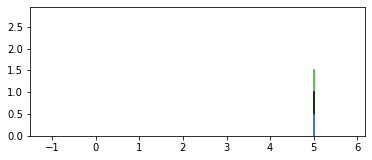

In [38]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

xmin = np.min([m.plotp[n,pp,'x'].value for n in range(1,N+1) for pp in m.pp])
xmax = np.max([m.plotp[n,pp,'x'].value for n in range(1,N+1) for pp in m.pp])
ymax = np.max([m.plotp[n,pp,'y'].value for n in range(1,N+1) for pp in m.pp])

def plot_pendulum(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([xmin-1, xmax+1])
    ax.set_ylim([     0, ymax+1])
    
    # plot link 1
    BodyLx = m.plotp[i,'bodyL','x'].value
    BodyLy = m.plotp[i,'bodyL','y'].value
    BodyRx = m.plotp[i,'bodyR','x'].value
    BodyRy = m.plotp[i,'bodyR','y'].value
    ax.plot([BodyLx,BodyRx],[BodyLy,BodyRy],color='xkcd:green')
    
    
    # plot link 2
    Hipx   = m.plotp[i,  'hip','x'].value
    Hipy   = m.plotp[i,  'hip','y'].value
    Knee1x = m.plotp[i,'knee1','x'].value
    Knee1y = m.plotp[i,'knee1','y'].value
    ax.plot([Hipx,Knee1x],[Hipy,Knee1y],color='xkcd:black')
    
    # plot prismatic joint
    Knee2x = m.plotp[i,'knee2','x'].value
    Knee2y = m.plotp[i,'knee2','y'].value
    ax.plot([Knee1x,Knee2x],[Knee1y,Knee2y],color='xkcd:red')
    
    # plot link 3
    Footx = m.plotp[i,'foot','x'].value
    Footy = m.plotp[i,'foot','y'].value
    ax.plot([Knee2x,Footx],[Knee2y,Footy],color='xkcd:blue')
    
update = lambda i: plot_pendulum(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True) # interval = frame time. 1/50 = 20 fps
# animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 1000*hm,repeat=True) # if you want it to play at the actual speed

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
# ani.Animation.save(animate,'placeholder.mp4', fps=int(1/h), dpi=300) # if you want to save the animation instead of embedding it

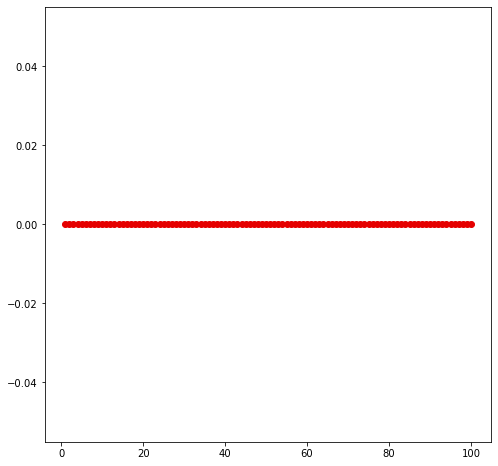

In [50]:
fig1, ax1 = plt.subplots(1,1,figsize=(8, 8)) #create axes

def plot_constr(i, m, ax):
    ax.clear()
    for n in range(1,N+1):
        A = m.GRF[n,'y'].value
        B = m.footp[n,'y'].value# + m.footv[n,'y','ps'].value + m.footv[n,'y','ng'].value
        ax.plot([n],[A*B], color='xkcd:red',marker='o')
#         ax.plot([n],[m.ground_penalty[n,'contact'].value], color='xkcd:green',marker='o')

plot_constr(N,m,ax1)

In [49]:
m.alpha.pprint()

alpha : Size=100, Index=N
    Key : Lower : Value               : Upper : Fixed : Stale : Domain
      1 :     0 :                None :     1 : False :  True :  Reals
      2 :     0 :   0.500000000008419 :     1 : False : False :  Reals
      3 :     0 :  0.4999999999995447 :     1 : False : False :  Reals
      4 :     0 : 0.49999999999957706 :     1 : False : False :  Reals
      5 :     0 :  0.4999999999996083 :     1 : False : False :  Reals
      6 :     0 : 0.49999999999963857 :     1 : False : False :  Reals
      7 :     0 :  0.4999999999996678 :     1 : False : False :  Reals
      8 :     0 :  0.4999999999996962 :     1 : False : False :  Reals
      9 :     0 :  0.4999999999997238 :     1 : False : False :  Reals
     10 :     0 : 0.49999999999975064 :     1 : False : False :  Reals
     11 :     0 : 0.49999999999977685 :     1 : False : False :  Reals
     12 :     0 : 0.49999999999980244 :     1 : False : False :  Reals
     13 :     0 :  0.4999999999998275 :     1 : Fal